<a href="https://colab.research.google.com/github/shadab4150/Plant-Pathology/blob/master/plant_pathology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip '/content/drive/My Drive/Dataset/plant-pathology-2020-fgvc7.zip' -d '/content/'
#!unzip '/content/drive/My Drive/Dataset/plant_pathology_small.zip' -d '/content/'

In [0]:
!unzip '/content/plant_pathology.zip' -d '/content/image_small/'

In [0]:
from fastai.vision import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import shutil


In [0]:
path = Path('/content/')

In [0]:
train = pd.read_csv(path/'train.csv')
test = pd.read_csv(path/'test.csv')

In [6]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


## As can been seen here so it is one hot encoded.

Count plot of different Features


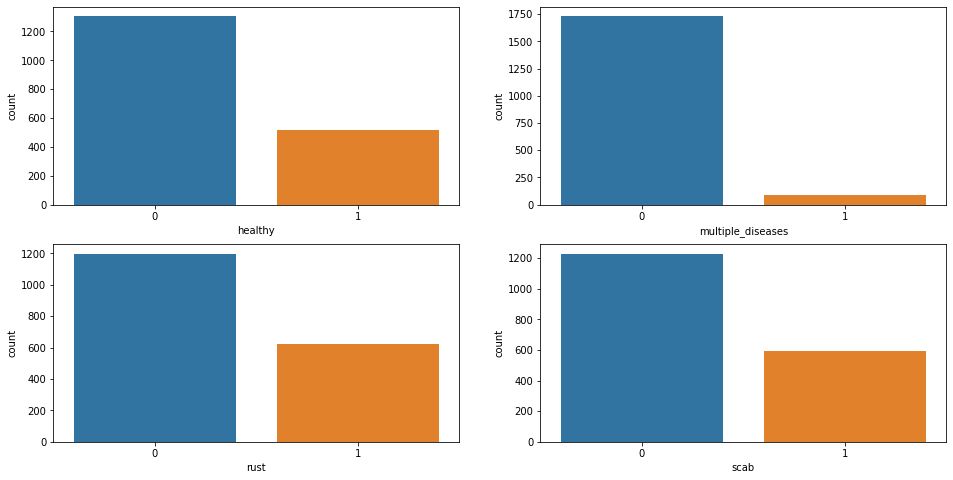

In [7]:
print('Count plot of different Features')
plt.figure(1,figsize=(16,8))
plt.subplot(221)
sns.countplot(x=train.healthy)
plt.subplot(222)
sns.countplot(x=train.multiple_diseases)
plt.subplot(223)
sns.countplot(x=train.rust)
plt.subplot(224)
sns.countplot(x=train.scab)
plt.show()

## These are quite big images

In [7]:
img = mpimg.imread(path/'images/Train_1.jpg');img.shape

(1365, 2048, 3)

In [7]:
image_list = train.image_id.tolist()
len(image_list)

1821

## Converting Images to small sizes 

In [0]:
import pylab
from tqdm import  tqdm,tnrange

In [14]:
for i in tnrange(1,desc='image'):
  pylab.figure(num=None,frameon=False ,figsize=(18, 8))
  pylab.subplot(111)
  loca = '/content/images/' + str(image_list[i]) +'.jpg'
  img = mpimg.imread(loca)
  plt.imshow(img)
  plt.axis('off')
  loc='/content/'+str(image_list[i])+'.png'
  pylab.savefig(loc)
  pylab.close('all')
  plt.close('all')

In [0]:
!cp '/content/test.csv' '/content/small_plant/'
!cp '/content/train.csv' '/content/small_plant/'
!cp '/content/plant_pathology.zip' '/content/small_plant/'

In [12]:
shutil.make_archive('plant_pathology_small', 'zip', '/content/small_plant/')

'/content/plant_pathology_small.zip'

In [0]:
!cp '/content/plant_pathology_small.zip' '/content/drive/My Drive/Dataset/'

## New Image size

In [9]:
open_image(path/'image_small/Train_0.png').shape

torch.Size([3, 288, 576])

In [7]:
cols = train.columns.tolist()[1:];cols

['healthy', 'multiple_diseases', 'rust', 'scab']

In [0]:
tfms = get_transforms(do_flip=True)

In [0]:
ts = (ImageList.from_df(test,path,folder='images',suffix='.jpg',cols='image_id'))

In [0]:
data = (ImageList.from_df(train,path,folder='image_small',suffix='.png',cols='image_id')
                .split_by_rand_pct(0.15,seed=23)
                .label_from_df(cols=cols,label_cls = MultiCategoryList, one_hot = True)
                .transform(size=256)
                .add_test(ts)
                .databunch(bs=128).normalize(imagenet_stats))

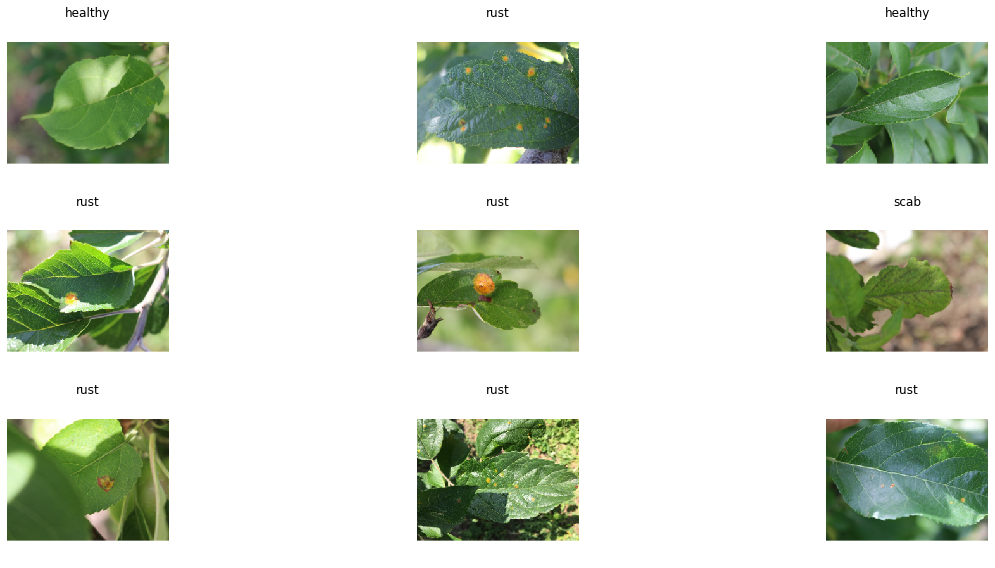

In [25]:
data.show_batch(rows=3,figsize=(20,8))

In [26]:
len(data.train_ds),len(data.valid_ds),len(data.test_ds),data.train_ds[0][0].shape

(1548, 273, 1821, torch.Size([3, 256, 256]))

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

In [11]:
learn = cnn_learner(data, models.resnet50 , metrics = [acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [12]:
import gc
gc.collect()

0

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


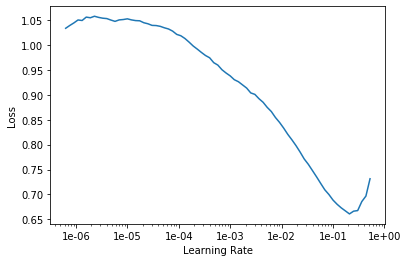

In [43]:
learn.lr_find()
learn.recorder.plot()

In [44]:
np.linspace(1e-2,1e-1,5)

array([0.01  , 0.0325, 0.055 , 0.0775, 0.1   ])

In [13]:
learn.fit_one_cycle( 10 , slice(1e-2) , moms = (0.8,0.7) )

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.697289,0.488415,0.618132,0.757152,00:18
1,0.509495,0.323883,0.766484,0.827512,00:14
2,0.366461,0.200824,0.904762,0.906245,00:14
3,0.263243,0.206085,0.923077,0.888627,00:14
4,0.195232,0.193835,0.934066,0.895604,00:15
5,0.146751,0.190339,0.940476,0.893773,00:15
6,0.112185,0.177575,0.940476,0.889499,00:15
7,0.086734,0.177002,0.942308,0.893773,00:15
8,0.067894,0.175864,0.942308,0.890720,00:15
9,0.053639,0.174721,0.942308,0.891941,00:15


In [22]:
gc.collect()

6341

In [23]:
learn.fit_one_cycle(8,max_lr=slice(1e-6,7.5250e-05),moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.005443,0.175970,0.945055,0.898657,00:15
1,0.005600,0.176710,0.945055,0.898657,00:15
2,0.005148,0.176972,0.945971,0.899267,00:15
3,0.005056,0.176251,0.946886,0.902930,00:15
4,0.005487,0.176918,0.945055,0.898657,00:15
5,0.005461,0.177572,0.945055,0.898657,00:14
6,0.005396,0.177731,0.945055,0.901709,00:15
7,0.005608,0.178921,0.945055,0.901709,00:14


In [25]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-5, 1e-2/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.021269,0.620204,0.886447,0.840659,00:17
1,0.035067,0.282954,0.932234,0.878510,00:16
2,0.032031,0.184408,0.955128,0.916972,00:15


In [0]:
learn.load('model91');

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-2 

In [19]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.081495,0.138887,0.956044,0.933630,02:18
1,0.085634,0.107689,0.964286,0.946886,02:18
2,0.075615,0.115164,0.960623,0.944444,02:18


In [0]:
preds = learn.get_preds(DatasetType.Test)

In [0]:
res=preds[0].numpy()

In [61]:
test_id = test['image_id'].values
submission = pd.DataFrame({'image_id': test_id})
submission = pd.concat([submission, pd.DataFrame(tot , columns =cols)], axis=1)

submission.to_csv('submission_plant_ens.csv', index=False)
submission.head(10)

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.008906,0.038157,0.979402,0.003732
1,Test_1,0.002147,0.026292,0.991938,0.004429
2,Test_2,0.002143,0.002560,0.000175,0.998395
3,Test_3,0.997383,0.000395,0.006656,0.001754
4,Test_4,0.002445,0.004625,0.993326,0.001652
5,Test_5,0.799313,0.076502,0.016044,0.018801
6,Test_6,0.979199,0.003112,0.032953,0.004155
7,Test_7,0.001046,0.001677,0.000989,0.997826
8,Test_8,0.071797,0.182920,0.030466,0.631984
9,Test_9,0.004037,0.036427,0.963014,0.014804


In [55]:
submission.isna().sum()

image_id             0
healthy              0
multiple_diseases    0
rust                 0
scab                 0
dtype: int64